In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/Shareddrives/CSE544_Project/covid_dataset

/content/drive/Shareddrives/CSE544_Project/covid_dataset


In [3]:
%ls

backup/
colab_pdf.py
COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv
covid_la_cleaned.csv
covid_la_cleaned_removed_outliers.csv
covid_md_cleaned.csv
covid_md_cleaned_removed_outliers.csv
__pycache__/
United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv
vacc_la_clean.csv
vacc_la_clean_removed_outliers.csv
vacc_md_clean.csv
vacc_md_clean_removed_outliers.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from scipy.stats import geom
from scipy.stats import binom

In [5]:
df_all = pd.read_csv('United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

In [46]:
df_md = pd.read_csv('covid_md_cleaned.csv')
df_la = pd.read_csv('covid_la_cleaned.csv')

In [47]:
df_md.head()

,Unnamed: 0,submission_date,state,tot_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at
0,33516,2020-01-22,MD,0,0,0.0,0,0.0,0.0,0,0.0,01/24/2020 12:00:00 AM
1,32577,2020-01-23,MD,0,0,0.0,0,0.0,0.0,0,0.0,01/25/2020 12:00:00 AM
2,31837,2020-01-24,MD,0,0,0.0,0,0.0,0.0,0,0.0,01/26/2020 12:00:00 AM
3,12958,2020-01-25,MD,0,0,0.0,0,0.0,0.0,0,0.0,01/27/2020 12:00:00 AM
4,14085,2020-01-26,MD,0,0,0.0,0,0.0,0.0,0,0.0,01/28/2020 12:00:00 AM


This function calculates the ecdf of a sorted dataframe. Basically returns an array like [ 1/n, 2/n, 3/n ... ]

In [48]:

def get_ecdf(df_sorted):
  ecdf = []
  count = 0
  for x in range(df_sorted.shape[0]):
    count += (1/df_sorted.shape[0])
    ecdf.append(count)
  return ecdf

Selecting last 3 months of 2021 data

In [49]:

df_3_months_md = df_md[(df_md['submission_date'] >= '2021-10-01') & (df_md['submission_date'] < '2022-01-01')]
df_3_months_la = df_la[(df_la['submission_date'] >= '2021-10-01') & (df_la['submission_date'] < '2022-01-01')]

Sort the dataframe in order of new_case column to find the ecdf

In [50]:
df_md_cases_sorted = df_3_months_md.sort_values('new_case').reset_index(drop=True)
df_md_cases_sorted['ecdf'] = get_ecdf(df_md_cases_sorted)
df_md_cases_ecdf = df_md_cases_sorted.drop_duplicates(subset='new_case', keep="last").reset_index(drop=True)

This function calculates max difference between ecdf and cdf of a distribution and returns the max difference and the x value at which this max difference occurs

In [51]:
def calc_max_diff(df_md_ecdf, distribution_col, col_name ):
  max_diff = 0
  x = df_md_ecdf.loc[0,col_name]
  for i in range(df_md_ecdf.shape[0]):
    F_x = df_md_ecdf.loc[i,distribution_col]
    F_x_neg = 0 if i == 0 else df_md_ecdf.loc[i-1, 'ecdf']
    F_x_pos = 1 if i == df_md_ecdf.shape[0] else df_md_ecdf.loc[i, 'ecdf']


    if abs(F_x_neg-F_x) > max_diff:
      max_diff = abs(F_x_neg-F_x)
      x = df_md_ecdf.loc[i,col_name]

    if abs(F_x_pos-F_x) > max_diff:
      max_diff = abs(F_x_pos-F_x)
      x = df_md_ecdf.loc[i,col_name]

  return (max_diff,x)

Function plots the ecdf and the distribution cdf with a dotted vertical line denoting the max diff x value.

In [55]:
def plot_ecdf(df_ecdf, distribution_col, col_name, x):
  plt.figure('KS 1-Sample Test eCDF', figsize=(7,4))
  plt.step(df_ecdf[col_name], df_ecdf['ecdf'], where='post', lw = 1.5, label='ECDF of {}'.format(col_name))
  plt.step(df_ecdf[col_name], df_ecdf[distribution_col], where='post', lw = 1.5, label=distribution_col)
  plt.axvline(x, linestyle="dashed", lw=1)
  plt.xlabel(col_name)
  plt.ylabel('eCDF')
  plt.title("1 sample KS test for {} and {}".format(col_name, distribution_col))
  plt.legend(loc='best')
  plt.grid()
  plt.show()

#KS Test


## 1 Sample KS test

### Cases data

#### 1) Poisson

In [53]:
# calculate sample mean of cases of state LA
sample_mean = df_3_months_la['new_case'].to_numpy().mean()
sample_var = df_3_months_la['new_case'].to_numpy().std()

Poisson lambda MME estimation =  958.2826086956521
max difference KS statistic = 0.49976784976523364


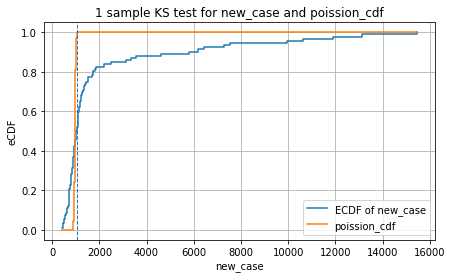

In [58]:
poisson_mme = sample_mean
print("Poisson lambda MME estimation = ",poisson_mme)
df_md_cases_ecdf['poission_cdf'] = df_md_cases_ecdf['new_case'].apply(lambda x: poisson.cdf(x, poisson_mme))
max_diff, x = calc_max_diff(df_md_cases_ecdf, 'poission_cdf','new_case')
print("max difference KS statistic =",max_diff)
plot_ecdf(df_md_cases_ecdf,'poission_cdf' , 'new_case', x)

In [59]:
if (max_diff > 0.05):
    print("Null Hypothesis is rejected. Therefore, the data is differently distributed")
else:
    print("Null Hypothesis holds. Therefore, the data is similarly distributed")

Null Hypothesis is rejected. Therefore, the data is differently distributed


#### 2) Geometric

Geometric lambda MME estimation =  0.0010435334951566435
max difference KS statistic = 0.4052613293065151


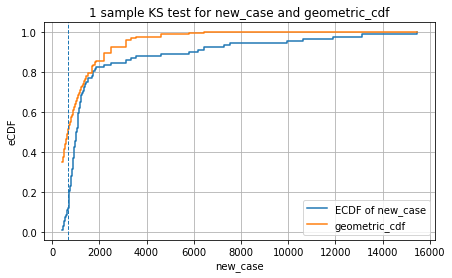

In [62]:
geometric_mme = 1/sample_mean
print("Geometric lambda MME estimation = ",geometric_mme)
df_md_cases_ecdf['geometric_cdf'] = df_md_cases_ecdf['new_case'].apply(lambda x: geom.cdf(x, geometric_mme))
max_diff, x = calc_max_diff(df_md_cases_ecdf, 'geometric_cdf','new_case')
print("max difference KS statistic =",max_diff)

plot_ecdf(df_md_cases_ecdf,'geometric_cdf' , 'new_case', x)

In [61]:
if (max_diff > 0.05):
    print("Null Hypothesis is rejected. Therefore, the data is differently distributed")
else:
    print("Null Hypothesis holds. Therefore, the data is similarly distributed")

Null Hypothesis is rejected. Therefore, the data is differently distributed


#### 3) Binomial

Binomial MME n = -853.98453776699
Binomial MME p = -1.1221310999393292
max difference KS statistic = 1.0


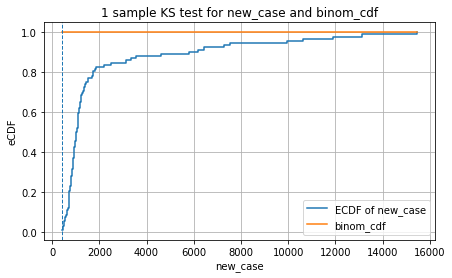

In [65]:
bin_n = (sample_mean**2)/(sample_mean - sample_var)
bin_p =  sample_mean/bin_n

print("Binomial MME n =",bin_n)
print("Binomial MME p =",bin_p)

df_md_cases_ecdf['binom_cdf'] = df_md_cases_ecdf['new_case'].apply(lambda x: binom.cdf(x, bin_n, bin_p))
max_diff, x = calc_max_diff(df_md_cases_ecdf, 'binom_cdf','new_case')

print("max difference KS statistic =",max_diff)

plot_ecdf(df_md_cases_ecdf,'binom_cdf' , 'new_case', x)

In [64]:
if (max_diff > 0.05):
    print("Null Hypothesis is rejected. Therefore, the data is differently distributed")
else:
    print("Null Hypothesis holds. Therefore, the data is similarly distributed")

Null Hypothesis is rejected. Therefore, the data is differently distributed


### 2) Deaths data



In [66]:
df_md_deaths_sorted = df_3_months_md.sort_values('new_death').reset_index(drop=True)
df_md_deaths_sorted['ecdf'] = get_ecdf(df_md_deaths_sorted)
df_md_deaths_ecdf = df_md_deaths_sorted.drop_duplicates(subset='new_death', keep="last").reset_index(drop=True)

In [67]:
sample_mean = df_3_months_la['new_death'].to_numpy().mean()
sample_var = df_3_months_la['new_death'].to_numpy().std()

a) Poisson

Poisson lambda MME estimation =  11.271739130434783
max difference KS statistic = 0.34870299910713265


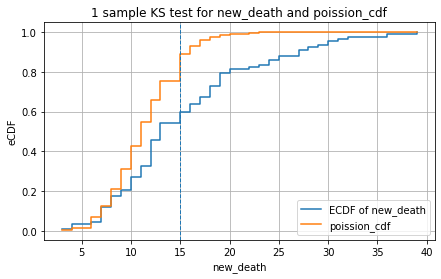

In [68]:
poisson_mme = sample_mean
print("Poisson lambda MME estimation = ",poisson_mme)
df_md_deaths_ecdf['poission_cdf'] = df_md_deaths_ecdf['new_death'].apply(lambda x: poisson.cdf(x, poisson_mme))
max_diff, x = calc_max_diff(df_md_deaths_ecdf, 'poission_cdf','new_death')

print("max difference KS statistic =",max_diff)

plot_ecdf(df_md_deaths_ecdf,'poission_cdf' , 'new_death', x)

In [69]:
if (max_diff > 0.05):
    print("Null Hypothesis is rejected. Therefore, the data is differently distributed")
else:
    print("Null Hypothesis holds. Therefore, the data is similarly distributed")

Null Hypothesis is rejected. Therefore, the data is differently distributed


b) Geometric

Geometric lambda MME estimation =  0.08871745419479267
max difference KS statistic = 0.43464088458562833


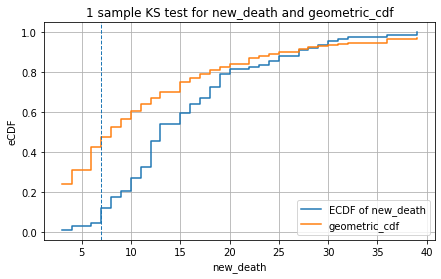

In [70]:
geometric_mme = 1/sample_mean
print("Geometric lambda MME estimation = ",geometric_mme)
df_md_deaths_ecdf['geometric_cdf'] = df_md_deaths_ecdf['new_death'].apply(lambda x: geom.cdf(x, geometric_mme))
max_diff, x = calc_max_diff(df_md_deaths_ecdf, 'geometric_cdf','new_death')

print("max difference KS statistic =",max_diff)
plot_ecdf(df_md_deaths_ecdf,'geometric_cdf' , 'new_death', x)

In [71]:
if (max_diff > 0.05):
    print("Null Hypothesis is rejected. Therefore, the data is differently distributed")
else:
    print("Null Hypothesis holds. Therefore, the data is similarly distributed")

Null Hypothesis is rejected. Therefore, the data is differently distributed


c) Binomial

Binomial MME n = 274.39661248904184
Binomial MME p = 0.04107827362804971
max difference KS statistic = 0.3542390041748824


/usr/local/lib/python3.7/dist-packages/scipy/stats/_discrete_distns.py:62: RuntimeWarning: floating point number truncated to an integer
  vals = special.bdtr(k, n, p)


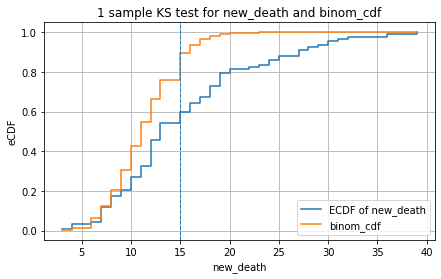

In [72]:
bin_n = (sample_mean**2)/(sample_mean - sample_var)
bin_p =  sample_mean/bin_n
print("Binomial MME n =",bin_n)
print("Binomial MME p =",bin_p)
df_md_deaths_ecdf['binom_cdf'] = df_md_deaths_ecdf['new_death'].apply(lambda x: binom.cdf(x, bin_n, bin_p))
max_diff, x = calc_max_diff(df_md_deaths_ecdf, 'binom_cdf','new_death')

print("max difference KS statistic =",max_diff)

plot_ecdf(df_md_deaths_ecdf,'binom_cdf' , 'new_death', x)

In [73]:
if (max_diff > 0.05):
    print("Null Hypothesis is rejected. Therefore, the data is differently distributed")
else:
    print("Null Hypothesis holds. Therefore, the data is similarly distributed")

Null Hypothesis is rejected. Therefore, the data is differently distributed


## 2 Sampled KS test

### 2 Sample Cases data

In [74]:
# get Fx-
def get_neg_fx(df, col_name, x):
    df_neg_fx = df.loc[df[col_name] < x, 'ecdf']
    F_neg = 0.0 if df_neg_fx.empty else df_neg_fx.max()
    return F_neg

In [75]:
# get Fx+
def get_pos_fx(df, col_name, x):
    df_pos_fx = df.loc[df[col_name] <= x, 'ecdf']
    F_pos = 0.0 if df_pos_fx.empty else df_pos_fx.max()
    return F_pos

In [76]:
def calc_max_diff(df1, df2, col_name ):
  max_diff = 0
  x = df1.loc[0,col_name]
  for i in range(df1.shape[0]):
    F_x1_neg = 0 if i == 0 else df1.loc[i-1, 'ecdf']
    F_x1_pos = 1 if i == df1.shape[0] else df1.loc[i, 'ecdf']

    F_x2_neg = get_neg_fx(df2, col_name, df1.loc[i, col_name])
    F_x2_pos = get_pos_fx(df2, col_name, df1.loc[i, col_name])

    if abs(F_x1_neg-F_x2_neg) > max_diff:
      max_diff = abs(F_x1_neg-F_x2_neg)
      x = df1.loc[i,col_name]

    if abs(F_x1_pos-F_x2_neg) > max_diff:
      max_diff = abs(F_x1_pos-F_x2_neg)
      x = df1.loc[i,col_name]

  return max_diff,x

In [77]:
def plot_ecdf(df1, df2, col_name, x):
  plt.figure('2 Sample KS test', figsize=(8,5))
  plt.step(df1[col_name], df1['ecdf'], where='post', lw = 1.5, label='ECDF of {}'.format(df1.loc[0,'state']))
  plt.step(df2[col_name], df2['ecdf'], where='post', lw = 1.5, label='ECDF of {}'.format(df2.loc[0,'state']))
  plt.axvline(x, linestyle="dashed", lw=1)
  plt.title("2 sample KS test for {}".format(col_name))
  plt.xlabel(col_name)
  plt.ylabel('eCDF')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

Same steps are repeated for 2 sample KS test as the 1 sample KS test

In [78]:
df_la_cases_sorted = df_3_months_la.sort_values('new_case').reset_index(drop=True)
df_la_cases_sorted['ecdf'] = get_ecdf(df_la_cases_sorted)
df_la_cases_ecdf = df_la_cases_sorted.drop_duplicates(subset='new_case', keep="last").reset_index(drop=True)

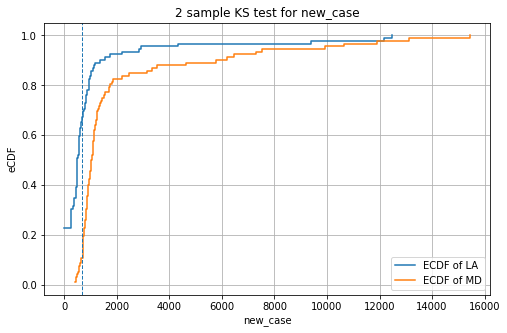

max difference KS statistic = 0.5652173913043483


In [79]:
if df_la_cases_ecdf.shape[0] < df_md_cases_ecdf.shape[0]:
  max_diff, x = calc_max_diff(df_la_cases_ecdf, df_md_cases_ecdf,'new_case')
  plot_ecdf(df_la_cases_ecdf, df_md_cases_ecdf, 'new_case', x)
else:
  max_diff, x = calc_max_diff(df_md_cases_ecdf, df_la_cases_ecdf, 'new_case')
  plot_ecdf(df_md_cases_ecdf, df_la_cases_ecdf, 'new_case', x)
print("max difference KS statistic =",max_diff)

In [80]:
if (max_diff > 0.05):
    print("Null Hypothesis is rejected. Therefore, the data is differently distributed")
else:
    print("Null Hypothesis holds. Therefore, the data is similarly distributed")

Null Hypothesis is rejected. Therefore, the data is differently distributed


### 2 sample deaths data

In [81]:
df_la_deaths_sorted = df_3_months_la.sort_values('new_death').reset_index(drop=True)
df_la_deaths_sorted['ecdf'] = get_ecdf(df_la_deaths_sorted)
df_la_deaths_ecdf = df_la_deaths_sorted.drop_duplicates(subset='new_death', keep="last").reset_index(drop=True)

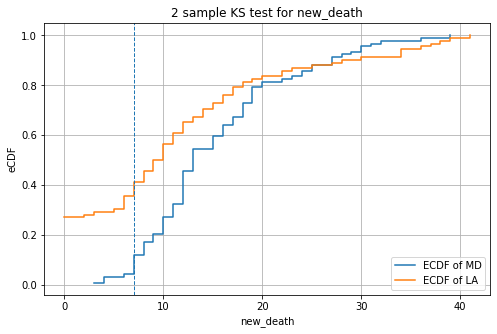

max difference KS statistic = 0.31521739130434767


In [82]:
if df_la_deaths_ecdf.shape[0] < df_md_deaths_ecdf.shape[0]:
  max_diff, x = calc_max_diff(df_la_deaths_ecdf, df_md_deaths_ecdf,'new_death')
  plot_ecdf(df_la_deaths_ecdf, df_md_deaths_ecdf, 'new_death', x)
else:
  max_diff, x = calc_max_diff(df_md_deaths_ecdf, df_la_deaths_ecdf, 'new_death')
  plot_ecdf(df_md_deaths_ecdf, df_la_deaths_ecdf, 'new_death', x)
print("max difference KS statistic =",max_diff)

In [83]:
if (max_diff > 0.05):
    print("Null Hypothesis is rejected. Therefore, the data is differently distributed")
else:
    print("Null Hypothesis holds. Therefore, the data is similarly distributed")

Null Hypothesis is rejected. Therefore, the data is differently distributed


# Permutation test


### a) cases

In [84]:
#This function creates n random permutations and check how many of them have a higher difference of means than the original distribution.
#returns the p value of such cases.
def permutation_test(X,Y, n):
  n1 = X.shape[0]
  n2 = Y.shape[0]

  t0 = np.abs(np.average(X) - np.average(Y))
  XY = np.concatenate((X,Y), axis=None)

  count = 0
  for i in range(n):
    np.random.shuffle(XY)
    rand_avg_diff = np.abs(np.average(XY[0:n1]) - np.average(XY[n1:]))
    if rand_avg_diff > t0:
      count += 1

  p = count/n
  print('p value = ',p)

  return p

In [85]:
md_cases_list = df_3_months_md['new_case'].to_numpy()
la_cases_list = df_3_months_la['new_case'].to_numpy()

p = permutation_test(md_cases_list, la_cases_list, 1000)


p value =  0.004


In [86]:
if (p<0.05):
    print("Null Hypothesis is rejected. Therefore, the data is differently distributed")
else:
    print("Null Hypothesis holds. Therefore, the data is similarly distributed")

Null Hypothesis is rejected. Therefore, the data is differently distributed


### b) deaths

In [87]:
md_death_list = df_3_months_md['new_death'].to_numpy()
la_death_list = df_3_months_la['new_death'].to_numpy()

p = permutation_test(md_death_list, la_death_list, 1000)

p value =  0.003


In [88]:
if (p<0.05):
    print("Null Hypothesis is rejected. Therefore, the data is differently distributed")
else:
    print("Null Hypothesis holds. Therefore, the data is similarly distributed")

Null Hypothesis is rejected. Therefore, the data is differently distributed


In [89]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic &> /dev/null
!jupyter nbconvert --to pdf /content/drive/Shareddrives/CSE544_Project/part_b/taskB.ipynb &> /dev/null